# Finding Correlation between shawarma and juice sales
The files that has the sales data is in google drive. so we need to mount the drive to get the files names and use auth and gspread to read those data.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
## Importing gspread forr googlesheets and google authenticcation for its access
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
## Getting names of google sheets
import subprocess as sp
files = []
months = ['November','December','January','February']
for month in months:
  files = files + sp.getoutput(f'ls "/content/gdrive/MyDrive/Avocado Analysis/Data sheets/{month}"').split('\n')

files = [file.split('.')[0] for file in files] ## removing the .gsheet extension
print("There are ",len(files)," files.")
print(files)

There are  103  files.
['10_11', '11_11', '1_11', '12_11', '13_11', '14_11', '15_11', '16_11', '17_11', '18_11', '19_11', '20_11', '21_11', '2_11', '22_11', '23_11', '24_11', '25_11', '26_11', '27_11', '28_11', '29_11', '30_11', '3_11', '4_11', '5_11', '6_11', '7_11', '8_11', '9_11', '10_12', '11_12', '1_12', '16_12', '17_12', '18_12', '19_12', '20_12', '21_12', '2_12', '22_12', '23_12', '24_12', '25_12', '26_12', '29_12', '31_12', '3_12', '4_12', '6_12', '7_12', '8_12', '9_12', '10_1', '11_1', '1_1', '12_1', '13_1', '14_1', '15_1', '16_1', '17_1', '18_1', '19_1', '20_1', '21_1', '2_1', '22_1', '23_1', '24_1', '25_1', '26_1', '27_1', '28_1', '29_1', '30_1', '31_1', '3_1', '4_1', '5_1', '6_1', '7_1', '8_1', '9_1', '1_2', '14_2', '15_2', '16_2', '18_2', '19_2', '20_2', '21_2', '22_2', '2_2', '23_2', '24_2', '25_2', '26_2', '27_2', '28_2', '3_2', '4_2', '5_2']


In [ ]:
  items = ['BEF', 'CHK', 'FULL', 'PLT', 'ORE', 'DF', 'SHM', 'CHO', 'CRT', 'DT', 'BDM', 'STW', 'GPS', 'COFE', 'COCO', 'AVO', 'APL', 'CUCU', 'WMLN', 'GPJ', 'ORG', 'PIN', 'LIM', 'MLIM']


In [ ]:

def aggregate(file_name):
  s_sum,eod = {},0
  s_sum = {item:0 for item in ['Date']+items}
  if file_name in ['1_11','2_11','23_11','25_11','2_12','8_12','9_12','21_12']: ## Outliers shop only partially open
    return None
  s_sum['Date'] = file_name
  day_sales = gc.open(file_name).sheet1.get_all_values()  ## returns list of list, each inner list is an order
  for index,row in enumerate(day_sales):
    try:
      if row[5]=='' and ''.join(row) == '-\n' :
        eod+=1
        if eod > 5:
          break
      for col in range(4):
        if row[col].isnumeric():
          s_sum[items[col]] += int(row[col])
      for col in range(5,15,2):
        if row[col].isnumeric():
          s_sum[row[col+1]] += int(row[col])
        else:
          break
    except:
      ## used for data cleaning
      print(file_name,index,": ",row)
  if sum(list(s_sum.values())[1:]) ==0:  ## Removing rows of holidays (all zero) to reduce error during averaging
    return None
  else:
    return s_sum


In [ ]:
import pandas as pd
book = pd.DataFrame(columns= ['Date']+items)
for month in [11,12,1,2]:
  for day in range(1,32):
    date = str(day)+'_'+str(month)
    if date in files:
      new_row = aggregate(date)
      if new_row != None:
        book = book.append(new_row,ignore_index = True)
display(book.head())

In [ ]:
## Saving the aggregate data  to drive
path =  "/content/gdrive/MyDrive/Avocado Analysis/Aggregate.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  book.to_csv(f)

In [ ]:
product_details = gc.open("Avacardo Product Details").sheet1.get_all_values()
menu={}
for row in range(1,len(product_details)):
  if product_details[row][0] =='':
    continue
  menu[product_details[row][0]] = int(product_details[row][3])
print(menu)


{'ORE': 50, 'DF': 60, 'SHM': 60, 'CHO': 60, 'CRT': 60, 'DT': 60, 'BDM': 70, 'STW': 80, 'GPS': 70, 'COFE': 70, 'COCO': 70, 'AVO': 80, 'APL': 70, 'CUCU': 40, 'WMLN': 40, 'GPJ': 50, 'ORG': 50, 'PIN': 50, 'LIM': 20, 'MLIM': 30, 'BEF': 120, 'CHK': 80, 'FULL': 130, 'PLT': 120}


In [ ]:
food_items = ['BEF','CHK','FULL','PLT']
book['Food_Revenue'],book['Drinks_Revenue'] =0,0
book['Food_volume'] ,book['Drinks_volume'] =0,0
for item in menu.keys():
  if item in food_items:
    book['Food_Revenue'] += (book[item]*menu[item])
    book['Food_volume'] += book[item]
  else:
    book['Drinks_Revenue'] += (book[item]*menu[item])
    book['Drinks_volume'] += book[item]
print(book)

    Date BEF  CHK FULL PLT ORE  DF SHM CHO CRT  ... WMLN GPJ ORG PIN LIM MLIM  \
0   3_11  22  146   15   3  34   9   0   0  33  ...   15   0   4   3   0    0   
1   4_11  23  137   12   2  25  12   0   2  26  ...   15   0   9  10   0    0   
2   5_11  28  169    6   2  36  13   0  31  34  ...    5  13  20   0   1    0   
3   6_11  34  170    9   4  67  23   0  19  27  ...   11   7  15  10   0    0   
4   7_11  34  158    5   0  15  20   0  16  33  ...    3   7   0   4   0    0   
..   ...  ..  ...  ...  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ...   
83  24_2   0    0    0   0   6   3   0   5  26  ...   12   0   4   2   7    5   
84  25_2   0    0    0   0  17   8   0  13  22  ...    6   9   5  12  17    0   
85  26_2   0    0    0   0  23  17   0   7  15  ...    7   4   7   8  23    2   
86  27_2   0    0    0   0  15  11   0  10  10  ...    8   6   8   9  16    9   
87  28_2   0    0    0   0  32   7   0  14   9  ...    0   2  10   8  11    8   

   Food_Revenue Drinks_Reve

In [ ]:
i_break = list(book['Date']).index('21_1')
book_1 = book.iloc[:i_break]  ## data before shutting down shawarma
#book -> data of both before and after shawarma shutdown

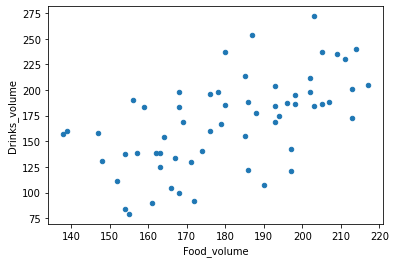

In [ ]:
import matplotlib.pyplot as mp
#Volume Scatter Plot
volume_series = pd.DataFrame(book_1,columns = ['Date','Food_volume','Drinks_volume'])
volume_series.plot.scatter(x ="Food_volume",y="Drinks_volume")
mp.show()

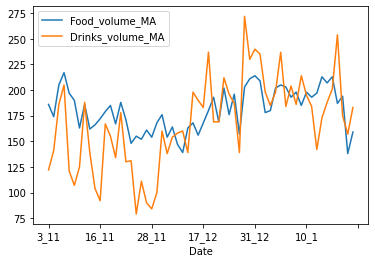

In [ ]:
## volume time series
MA_window = 1
volume_series['Food_volume_MA']=volume_series['Food_volume'].rolling(MA_window).mean()
volume_series['Drinks_volume_MA']=volume_series['Drinks_volume'].rolling(MA_window).mean()


volume_series.plot(x ="Date",y=['Food_volume_MA','Drinks_volume_MA'],kind ='line')
mp.show()

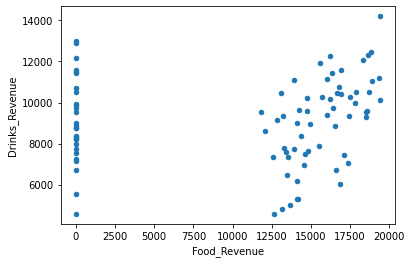

In [ ]:
Revenue_series = pd.DataFrame(book,columns = ['Date','Food_Revenue','Drinks_Revenue'])# Drinks_Revenue Food_volume Drinks_volume])
Revenue_series.plot.scatter(x ="Food_Revenue",y="Drinks_Revenue")
mp.show()

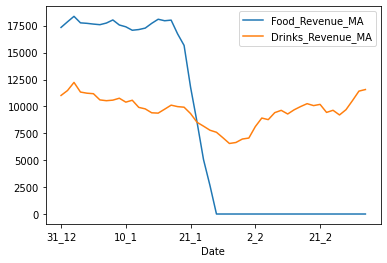

In [ ]:
## volume time series
MA_window = 5
Revenue_series['Food_Revenue_MA']=Revenue_series['Food_Revenue'].rolling(MA_window).mean()
Revenue_series['Drinks_Revenue_MA']=Revenue_series['Drinks_Revenue'].rolling(MA_window).mean()


Revenue_series.iloc[40:].plot(x ="Date",y=['Food_Revenue_MA','Drinks_Revenue_MA'],kind ='line')
mp.show()

In [ ]:
print("Correlation between food and drinks volume")
print(volume_series.corr())
print("\nCorrelation between food and drinks volume")
print(Revenue_series.corr())

print("\nThe correlation between food and juice can be classified as moderate")

Correlation between food and drinks volume
                  Food_volume_MA  Drinks_volume_MA
Food_volume_MA          1.000000          0.584604
Drinks_volume_MA        0.584604          1.000000

Correlation between food and drinks volume
                   Food_Revenue_MA  Drinks_Revenue_MA
Food_Revenue_MA           1.000000           0.149211
Drinks_Revenue_MA         0.149211           1.000000

The correlation between food and juice can be classified as moderate
